# Influence function - standard error

In [2]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import random
import math
import scipy
from scipy import stats
from random import choice
import networkx as nx
import json
from networkx.readwrite import json_graph
import line_profiler
import IPython
ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [3]:
import findspark
import os
findspark.init()
import pyspark
sc = pyspark.SparkContext()

In [41]:
# Load network graph
with open("graph/nc_full.json", "r") as graph_data:
    graph_data = json.load(graph_data)
    NC_digraph = json_graph.node_link_graph(graph_data)

### Calculate variance of simulation results

In [83]:
def activateNodesOpt(maxIt=10):

    activated = set()
    explored = set()
    
    start = random.choice(NC_digraph.nodes(), 1)
    
    nodes = [start[0]]

    activated.add(start[0])
    
    countIt = 0
    
    successors = []
    
    while len(nodes)>0 and countIt<maxIt:

        countIt +=1
        
        startNode = nodes[0]

        if startNode not in explored:

            explored.add(startNode)

            successors = []

            for succNode in NC_digraph.succ[startNode]:

                if succNode not in activated:

                    alpha = NC_digraph[startNode][succNode]['weight']
                    beta = NC_digraph.node[succNode]['review_count']

                    randUnif = random.uniform(0,1)
                    randBeta = np.sqrt(random.beta(alpha, beta))

                    if randUnif < randBeta:
                        activated.add(succNode)
                        successors.append(succNode)

        nodes = nodes[1:]
        nodes = nodes + successors

    return len(activated)

def activateNodesLoop(N):

    result = []

    for n in xrange(N):
        result.append(float(activateNodesOpt()))
        
    return np.mean(result)

In [84]:
%time test = activateNodesLoop(100)

CPU times: user 19.4 ms, sys: 3.96 ms, total: 23.4 ms
Wall time: 21.1 ms


Mini-graph:
CPU times: user 19.4 ms, sys: 3.96 ms, total: 23.4 ms
Wall time: 21.1 ms

**Plot standard error as a function of N:**

In [93]:
plot_range = range(100,1150,50)

In [94]:
for k in plot_range: 
    runs = sc.parallelize(range(100), 4)
    results = runs.map(lambda x: activateNodesLoop(k))
    results_list = results.collect()
    fd = open("data/SE-NC_full-N=" + str(k) + ".json","w")
    json.dump(results_list, fd)
    fd.close()
    del results

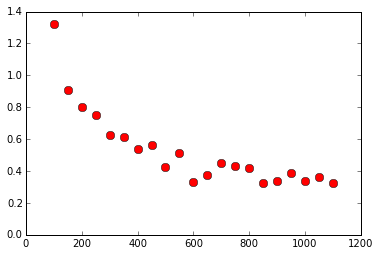

In [95]:
stdErr = dict()

for k in plot_range:

    with open("data/SE-NC_full-N=" + str(k) + ".json", "r") as fd:
        results = json.load(fd)
        
    stdErr[k] = np.std(results)
    
plt.plot(stdErr.keys(), stdErr.values(), 'o-', color='r', linestyle='None', markersize=8)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.show()

In [96]:
y = [math.log(i) for i in stdErr.values()]
x = [math.log(i) for i in stdErr.keys()]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

In [97]:
print 'lambda = %f' % (-slope)
print 'alpha = %f' % (math.exp(intercept))

lambda = 0.551522
alpha = 15.142047


Check results with log-plot:

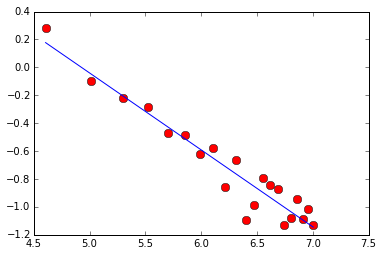

In [101]:
keys = [math.log(i) for i in stdErr.keys()]
keys.sort()
solution = [intercept + slope*n for n in keys]

plt.plot(x, [math.log(i) for i in stdErr.values()], 'o-', color='r', linestyle='None', markersize=8)
plt.plot(keys, solution)
# plt.xlim(xmin=4)
# plt.ylim(ymin=-1)
plt.show()